# Road Pathfinder with Capacity Contraints

In [1]:
import os
import sys
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
sys.path.insert(0, r'../../../quetzal')

from quetzal.model import stepmodel

SQLalchemy is not installed. No support for SQL output.


In [2]:
is_lambda = (os.environ.get("AWS_LAMBDA_FUNCTION_NAME") is not None)

if is_lambda:
    model_folder = 's3://quetzal-paris/dev'
    training_folder = os.environ.get("LAMBDA_TASK_ROOT")
else:
    model_folder = '../../model'
    training_folder = '../..'
    
input_folder = training_folder + '/inputs/'

## Road Model

In [3]:
sm = stepmodel.read_zippedpickles(model_folder + '/{scen}/aon_pathfinder'.format(scen=scenario))

distribution = stepmodel.read_zippedpickles(model_folder + '/{scen}/distribution'.format(scen=scenario))
sm.volumes = distribution.volumes

coordinates_unit: 100%|██████████| 3/3 [00:00<00:00, 1035.89it/s]


In [4]:
# Each link can have its own capacity
sm.road_links['capacity'] = 2000

# Keep relevant OD
v = sm.volumes.set_index(['origin', 'destination'])["car_owner"]
od_set = set(v.loc[v>1].index)

# Iterative Road Patfinder

In [5]:
constrained = sm.copy()
free = sm.copy()

constrained.step_road_pathfinder(method='BFW',
                             tolerance=0.01,
                             maxiters=50,
                             od_set=od_set,
                             volume_column='car_owner',
                             log=True,
                             num_cores=1,
                             access_time='time')

vdf not found in road_links columns. Values set to 'default_bpr'
alpha not found in road_links columns. Values set to 0.15
beta not found in road_links columns. Values set to 4
limit not found in road_links columns. Values set to 20
penalty not found in road_links columns. Values set to 0
iteration | Phi |  Rel Gap (%)
0 0.1609 35.593
1 0.15 17.074
2 0.1422 7.554
3 0.1422 3.436
4 0.2 1.706
5 0.5047 0.875
6 0.7484 0.459
7 0.8 0.125
8 0.8 0.02
9 0.0984 0.346
10 0.8 0.09
11 0.8 0.023
12 0.8 0.006


In [6]:
constrained.to_zippedpickles(model_folder + '/{scen}/constrained_road_pathfinder'.format(scen=scenario))

relgap: 100%|██████████| 33/33 [00:01<00:00, 25.23it/s]                 


# PLOT

In [7]:
if manual:
    constrained.analysis_car_los()
    constrained.car_los[('car_owner', 'probability')] = 1
    constrained.step_car_assignment(volume_column='car_owner')

    free.analysis_car_los()
    free.car_los[('car_owner', 'probability')] = 1
    free.step_car_assignment(volume_column='car_owner')
    free.road_links['flow'] = free.road_links[('car_owner', 'car')].fillna(0)

AttributeError: LineCollection.set() got an unexpected keyword argument 'scale'

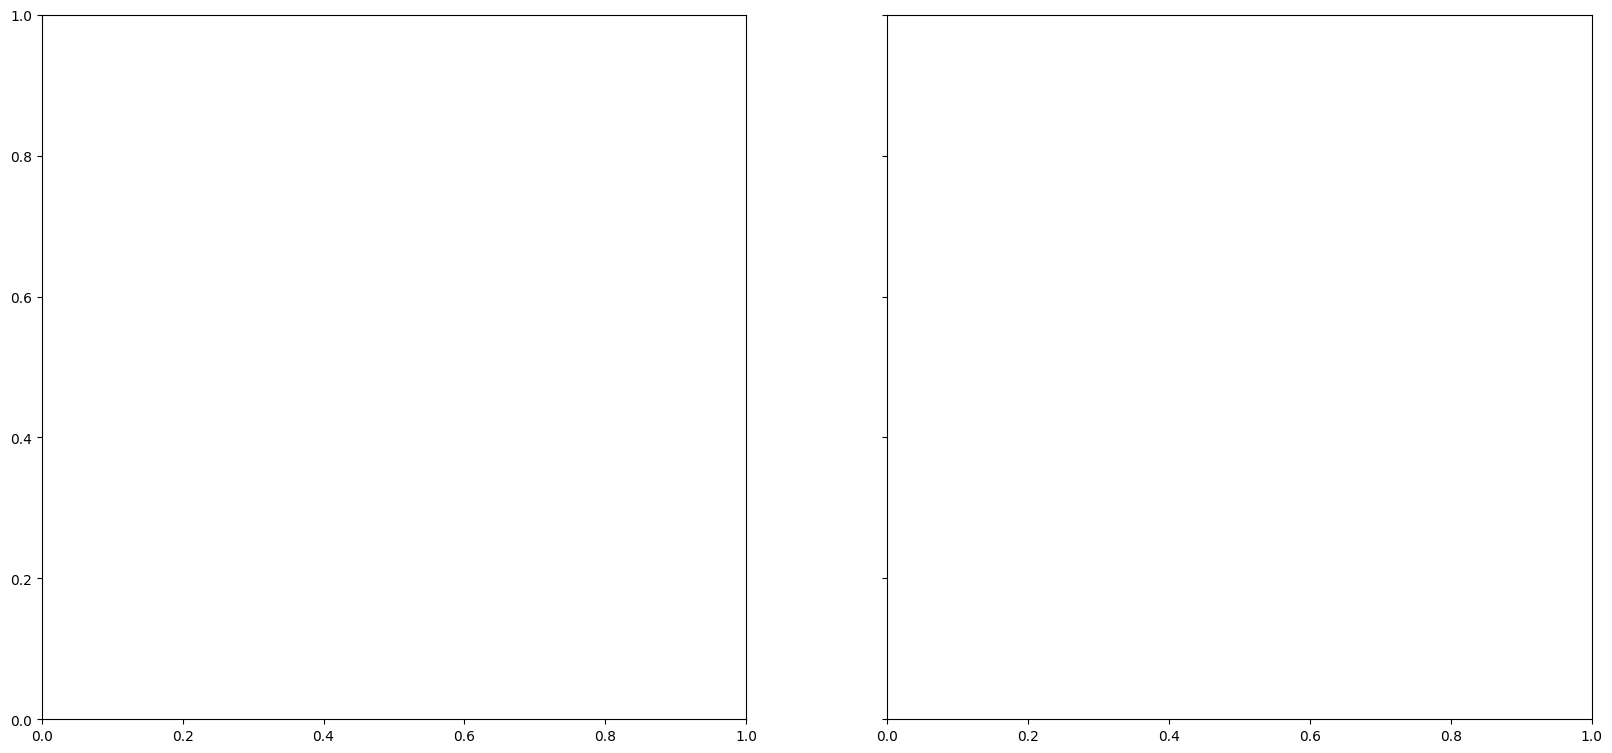

In [8]:
if manual:
    import matplotlib.pyplot as plt

    free.car_los = free.car_los.set_index(['origin', 'destination']).loc[od_set].reset_index()
    fig, axes = plt.subplots(ncols=2, sharey=True, sharex=True, figsize=[20, 20])

    axes[0].set_aspect('equal')
    axes[1].set_aspect('equal')

    from syspy.syspy_utils import data_visualization as dv
    bandwidth = dv.bandwidth
    power=0.5
    lv = [100, 1000, 2000, 5000, 7000]

    url = 'http://a.basemaps.cartocdn.com/dark_nolabels/tileZ/tileX/tileY.png'
    plot = bandwidth(
        free.road_links.loc[free.road_links['flow'] > 0], value_column='flow',
        power=0.5, figsize=[25, 15], scale=0.5, legend_values=lv, 
        label_kwargs={'color':'white', 'fontsize':16}, ax=axes[0]
    )
    dv.add_basemap(plot, url=url, zoom=12)
    plot.set_title("Free assignment")

    plot = bandwidth(
        constrained.road_links.loc[constrained.road_links['flow'] > 0], value_column='flow',
        power=0.5, figsize=[25, 15], scale=0.5, legend_values=lv, 
        label_kwargs={'color':'white', 'fontsize':16}, ax=axes[1]
    )
    dv.add_basemap(plot, url=url, zoom=12)
    plot.set_title("Constrained assignment")
    fig.tigh_layout=True

In [ ]:
if manual:
    c = constrained.car_los.groupby(['origin', 'destination'])['actual_time'].min()
    f = free.car_los.groupby(['origin', 'destination'])['actual_time'].min()
    df = pd.DataFrame([c, f], index=['constrained', 'free']).T
    df.plot(kind='scatter', y='constrained', x='free', figsize=[10, 10], s=1)